# Prediction of radiotherapy plan violation from spatial arrangement of target and organ at risk structures using deep learning

_By Phillip Hungerford,  University of New South Wales_

## PointNet Basic Model Testing

In [6]:
from google.colab import drive
drive.mount('/content/drive')

!cd drive

!cd My Drive

!cd Dissertation/5_Code/1_code

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 0: cd: too many arguments
/bin/bash: line 0: cd: Dissertation/5_Code/1_code: No such file or directory
drive  sample_data


In [7]:
cd drive

/content/drive


In [8]:
cd My Drive

/content/drive/My Drive


In [9]:
cd Dissertation/5_Code/1_code

/content/drive/My Drive/Dissertation/5_Code/1_code


In [10]:
ls

 3D_medical_visualisation_script.py   my_model4096.h5
 data_prep.py                         original-voxel-model.ipynb
'EDA&PreProcessing.ipynb'             plot.png
 keras-test.ipynb                     PointNetBasic.ipynb
 model_1024.h5                        PointNetFull.ipynb
 my_model10204D.h5                    __pycache__/
 my_model1024xyzl.h5                  tf_util.py
 my_model_16_16_16.h5                 trainHistoryDict3768
 my_model20454D.h5                    train.py
 my_model31404D.h5                    voxel-model.ipynb
 my_model3140.h5                      voxels.ipynb
 my_model3768.h5                      weights.h5


### 3.1. Install Dependencies

In [0]:
# for reading the ply files 
import numpy as np

# To time 
import time

# PointNet Basic


## Model 2: Extra-column (n,1024,4) -> (x,y,z,l).

Training shape is:  (182, 3140, 4)
Validation shape is:  (46, 3140, 4)
Test shape is:  (58, 3140, 4)
Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3140, 64)          320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 3140, 64)          256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3140, 64)          4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 3140, 64)          256       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3140, 64)          4160      
_________________________________________________________________
batch_normalization_3 (Batch (None, 3140, 64)          256       
___________________________

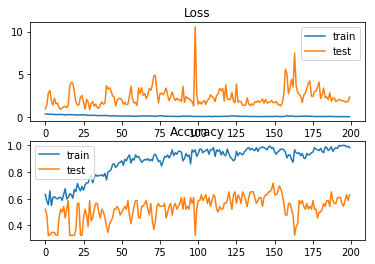

In [12]:
################################################################################
import numpy as np

# fix random seed for reproducibility
seeds=61
from numpy.random import seed
import random
random.seed(seeds)
seed(seeds)

from tensorflow import set_random_seed
set_random_seed(1)
################################################################################
# Load 3768 data 
# num_points=3768
# X = np.load('../2_pipeline/3768-body-xyzl.npy')

# Load 3140 data that excludes the body
num_points=3140
X = np.load('../2_pipeline/3140-xyzl.npy')
y = np.load('../2_pipeline/labels.npy')

from sklearn.model_selection import train_test_split

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

#from keras.utils import to_categorical
#y_test = to_categorical(y_test)
#y_train = to_categorical(y_train)

print('Training shape is: ', X_train.shape)
print('Validation shape is: ', X_val.shape)
print('Test shape is: ', X_test.shape)

################################################################################
# Basic PointNet Keras
################################################################################
# Import dependencies
import numpy as np
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, MaxPooling1D, Convolution1D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD
################################################################################
# Hyperparameters 
max_epochs=200
batch_size=32
dropout_rate = 0.5
opt = 'adam'
#opt = SGD(lr=0.0001, momentum=0.9)

# Class weights
class_weight = {0: 0.2,
                1: 0.8}
################################################################################
### POINTNET ARCHITECTURE
################################################################################
# Point functions (MLP implemented as conv1d)
model = Sequential()
model.add(Convolution1D(64, 1, input_shape=(num_points, 4), activation='relu'))
model.add(BatchNormalization())
model.add(Convolution1D(64, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Convolution1D(64, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Convolution1D(128, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Convolution1D(1024, 1, activation='relu'))
model.add(BatchNormalization())

# Symmetric function: max pooling
model.add(MaxPooling1D(pool_size=num_points))

#fully connected
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

 # MLP on global point cloud vector
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

################################################################################
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs,\
                    shuffle=True, verbose=0, validation_data=(X_val, y_val),\
                    class_weight=class_weight)
################################################################################

# Save model
#import pickle

# Save history
#with open('/trainHistoryDict', 'wb') as file_pi:
        #pickle.dump(history.history, file_pi)

# Save model
#from keras.models import load_model
#model.save('my_model'+str(num_points)+'4D.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

################################################################################

# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Average loss of: ", scores[0])
print("Average accuracy of: ", scores[1])

################################################################################
# Classification Report
from sklearn.metrics import classification_report
# make predictions on the test set
y_pred = model.predict(X_test)
 
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(y_true=y_test, y_pred=y_pred.round()))

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

################################################################################
import matplotlib.pyplot as plt
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

################################################################################

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

################################################################################


###################### Model Performance ############################

#####################################################################

Train: 1.000, Test: 0.707

#####################################################################


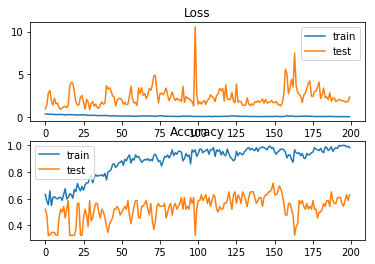


#####################################################################

Our test confusion matrix yields: 
[[25 11]
 [ 6 16]]

#####################################################################

Classfication Report for test:
               precision    recall  f1-score   support

         0.0       0.81      0.69      0.75        36
         1.0       0.59      0.73      0.65        22

   micro avg       0.71      0.71      0.71        58
   macro avg       0.70      0.71      0.70        58
weighted avg       0.73      0.71      0.71        58


#####################################################################

Our testing AUC for ann is:  0.7108585858585859


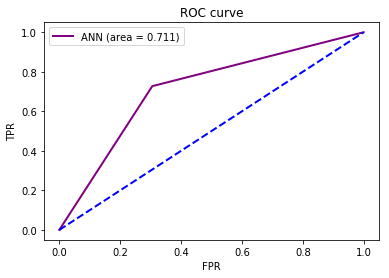


#####################################################################


In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("\n###################### Model Performance ############################")
print("\n#####################################################################")
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
print("\n#####################################################################")
################################################################################
import matplotlib.pyplot as plt
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

################################################################################

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

################################################################################
print("\n#####################################################################")
# Create the confusion matrix
ann_cm = confusion_matrix(y_true = y_test, y_pred = y_pred.round())
print("\nOur test confusion matrix yields: ")
print(ann_cm)
print("\n#####################################################################")

#Classification report
ann_report = classification_report(y_test, y_pred.round())
print("\nClassfication Report for test:\n", ann_report)
print("\n#####################################################################")

#Calculate AUC score
from sklearn.metrics import roc_auc_score
ann_auc = roc_auc_score(y_test, y_pred.round())
print("\nOur testing AUC for ann is: ", ann_auc)

from sklearn.metrics import roc_curve
fpr_ann, tpr_ann, thresholds_ann = roc_curve(y_test, y_pred.round())

# Plot AUC 
plt.figure()
plt.plot(fpr_ann, tpr_ann, color='purple', lw=2, label='ANN (area = {:.3f})'.format(ann_auc))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("\n#####################################################################")

In [0]:
# Save model
import pickle

# Save history
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

# Save model
from keras.models import load_model
model.save('my_model'+str(num_points)+'.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

K FOLDS Cross validated score

In [0]:
# define 5-fold cross validation test harness
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=61)
ann_cv_scores = []

#Run loop for manual 5-fold cross validation
for train, test in kfold.split(X, y):
    #scale data
    scaler = StandardScaler()
    #fit on training
    scaler.fit(X.iloc[train])
    #build model with optimized parameters
    model = Sequential()
    model.add(Dense(H1, input_dim=8, activation='selu')) #use optimized hidden layer size
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) #with optimized optimizers
    # Fit the model
    model.fit(scaler.transform(X.iloc[train]), y[train], epochs=150, batch_size=10, verbose=0)
    y_pred_ann = model.predict(scaler.transform(X.iloc[test]))
    scores = roc_auc_score(y[test], y_pred_ann)
    ann_cv_scores.append(scores)

ann_auc_cv = numpy.mean(ann_cv_scores)
print("ANN CV score: ", ann_auc_cv)

print("\n#####################################################################")

Grid search

In [0]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Define the Pipeline we will use
Scaler = StandardScaler()
Log_Reg = LogisticRegression(penalty = 'l2')

pipe = Pipeline([('Transform', Scaler), ('Estimator', Log_Reg)])

# Define the parameter grid
param_grid = {'Estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'Estimator__class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, \
                                          {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, \
                                          {0:0.5, 1:0.5}]}
              

print("Parameter grid:")
print("class_weight: {}".format(param_grid['Estimator__class_weight']))
print("C: {}".format(param_grid['Estimator__C']))

# Now initialise the GridSearchCV class by passing it the pipeline we have created
grid_search=GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1_macro')

# We stratify in order to have the same number of classes in the different splits.
X_train, X_test, y_train, y_test = \
train_test_split(X, y_binary, random_state=0, stratify=y_binary, test_size=0.2)

## Find the best parameters
# It takes a while to run ...
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation f1 score: {:.4f}".format(grid_search.best_score_))

## Visualise grid results
import mglearn
import warnings; warnings.simplefilter('ignore') #prevent warnings

# convert results to DataFrame
results = pd.DataFrame(grid_search.cv_results_) 
# show the first few rows 
display(results[:][:5])

In [0]:
# Load model.
#model = load_model('my_model10204D.h5')

## 99. Cross Validation beta
Note using different activation and loss functions as opposed to previous models. 

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy

# Load 1024 data 
X = np.load('../2_pipeline/1020-4D.npy')
y = np.load('../2_pipeline/labels.npy')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(X, y):
    ### POINTNET ARCHITECTURE
    
    # Point functions (MLP implemented as conv2d
    model = Sequential()
    model.add(Convolution2D(64, 1, input_shape=(num_points, 3, 3), activation='relu'))
    model.add(Convolution2D(64, 1, activation='relu'))
    model.add(Convolution2D(64, 1, activation='relu'))
    model.add(Convolution2D(128, 1, activation='relu'))
    model.add(Convolution2D(1024, 1, activation='relu'))

    # Symmetric function: max pooling
    model.add(MaxPooling2D(pool_size=(num_points,3), strides=None, padding='valid', data_format=None))

    #fully connected
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.add(Flatten())

    # Compile model
    # MLP on global point cloud vector
    model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

acc: 69.44%
acc: 69.44%
acc: 69.01%
acc: 30.99%
59.72% (+/- 16.59%)


The model with 1024 points scored:
* Test loss: 0.8002310043887089
* Test accuracy: 0.631578951132925

The model with body and 4096 points scored:
* Test loss:  1.2039089792653135
* Test accuracy:  0.6210526353434512

The model without the body with 4096 points scored:
* Test loss:  0.9736735845866956
* Test accuracy:  0.5894736785637705

The model without the body and 1024 points scored:
* Test loss: x
* Test accuracy: x

Model with 4096 points scored:
* Test loss of: 1.2039089792653135
* Test accuracy of: 0.6210526353434512

## Apply a grid search for hyperparameter optimization